In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
Bio_path = 'raw_data/naiades_export/France_entiere/Biologie(i2M2)/resultat.csv'

In [3]:
Bio_df = pd.read_csv(Bio_path, sep=';', header=0)


/tmp/ipykernel_2182758/1746327959.py:1: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  Bio_df = pd.read_csv(Bio_path, sep=';', header=0)


In [4]:
Bio_df.columns

Index(['CdStationMesureEauxSurface', 'LbStationMesureEauxSurface',
       'CdPointEauxSurf', 'DateDebutOperationPrelBio', 'CdSupport',
       'LbSupport', 'DtProdResultatBiologique', 'HeureResultat',
       'CdParametreResultatBiologique', 'LbLongParametre',
       'ResIndiceResultatBiologique', 'CdUniteMesure', 'SymUniteMesure',
       'CdRqIndiceResultatBiologique', 'MnemoRqAna', 'CdMethEval',
       'RefOperationPrelBio', 'CdProducteur', 'NomProducteur',
       'CdAccredRsIndiceResultatBiologique',
       'MnAccredRsIndiceResultatBiologique'],
      dtype='object')

In [5]:
unique_values = Bio_df[Bio_df['LbLongParametre'].str.contains('I2M2', na=False)]['LbLongParametre'].unique()
print(unique_values)


['Indice Invertébrés Multimétrique (I2M2)'
 "Nombre de taxons contributifs de l'I2M2"
 "Métrique Richesse Taxonomique de l'I2M2"
 "Métrique Ovoviviparite de l'I2M2" "Métrique Polyvoltinisme de l'I2M2"
 "Métrique ASPT de l'I2M2" "Métrique Indice de Shannon de l'I2M2"]


#### Clean up the data

In [6]:
Bio_df = Bio_df[Bio_df['LbLongParametre'] == 'Indice Invertébrés Multimétrique (I2M2)']

columns_to_keep = ['ResIndiceResultatBiologique', 'LbStationMesureEauxSurface', 'HeureResultat','DateDebutOperationPrelBio']
Bio_df = Bio_df[columns_to_keep]


#### Data Exploration

In [7]:
# NaN Rate
nan_rate = Bio_df.isnull().mean() * 100

# Column Data Types
column_data_types = Bio_df.dtypes

# Statistics on Numerical Columns
numerical_stats = Bio_df.describe()

# Analysis for Categorical Columns
categorical_columns = Bio_df.select_dtypes(include=['object']).columns
categorical_analysis = {col: Bio_df[col].value_counts() for col in categorical_columns}

# Output Results
print("NaN Rate:\n", nan_rate)
print("\nColumn Data Types:\n", column_data_types)
print("\nStatistics for Numerical Columns:\n", numerical_stats)
print("\nCategorical Columns Analysis:")
for col, data in categorical_analysis.items():
    print(f"\nColumn: {col}\n", data)


NaN Rate:
 ResIndiceResultatBiologique     0.000000
LbStationMesureEauxSurface      0.000000
HeureResultat                  66.644361
DateDebutOperationPrelBio       0.000000
dtype: float64

Column Data Types:
 ResIndiceResultatBiologique    float64
LbStationMesureEauxSurface      object
HeureResultat                   object
DateDebutOperationPrelBio       object
dtype: object

Statistics for Numerical Columns:
        ResIndiceResultatBiologique
count                 38854.000000
mean                      0.526446
std                       0.237405
min                       0.000000
25%                       0.352325
50%                       0.561800
75%                       0.718575
max                       1.000000

Categorical Columns Analysis:

Column: LbStationMesureEauxSurface
 ROTJA A PY                              17
La Seye à La Rouquette                  17
LOUE A MOUTHIER-HAUTE-PIERRE 1          16
ISSOLE A STE-ANASTASIE-SUR-ISSOLE       16
La Berlande à Paizay-le-Tort

### Traitement des NaN 

In [8]:
# On met toutes les heures Nan à 00:00:00 (toutes les autres heures sont à 00:00:00 de base)

# Set NaN values in 'HeureResultat' to midnight ('00:00:00')
Bio_df['HeureResultat'] = Bio_df['HeureResultat'].fillna('00:00:00')

# Display the DataFrame to verify the changes
print(Bio_df.head())


     ResIndiceResultatBiologique LbStationMesureEauxSurface HeureResultat  \
54                         0.205    LA SENSÉE À ETAING (62)      00:00:00   
66                         0.236    LA SENSÉE À ETAING (62)      00:00:00   
76                         0.096    LA SENSÉE À ETAING (62)      00:00:00   
87                         0.183    LA SENSÉE À ETAING (62)      00:00:00   
241                        0.403    LA SLACK À RINXENT (62)      00:00:00   

    DateDebutOperationPrelBio  
54                 2018-07-10  
66                 2019-06-26  
76                 2020-07-22  
87                 2021-07-28  
241                2018-07-11  


### Traitement du temps

In [9]:
# Concatenate the date and time into a single string
Bio_df['Date'] = Bio_df['DateDebutOperationPrelBio'] + ' ' + Bio_df['HeureResultat']

# Convert the concatenated string into a DateTime object
Bio_df['Date'] = pd.to_datetime(Bio_df['Date'])

# Drop the 'DateDebutOperationPrelBio' and 'HeureResultat' columns
Bio_df = Bio_df.drop(columns=['DateDebutOperationPrelBio', 'HeureResultat'])

# Display the DataFrame to verify the changes
print(Bio_df.head())


     ResIndiceResultatBiologique LbStationMesureEauxSurface       Date
54                         0.205    LA SENSÉE À ETAING (62) 2018-07-10
66                         0.236    LA SENSÉE À ETAING (62) 2019-06-26
76                         0.096    LA SENSÉE À ETAING (62) 2020-07-22
87                         0.183    LA SENSÉE À ETAING (62) 2021-07-28
241                        0.403    LA SLACK À RINXENT (62) 2018-07-11


#### Détails

In [10]:
Bio_df.rename(columns={'ResIndiceResultatBiologique': 'i2M2'}, inplace=True)


#### Réarrangement du Dataset en time series

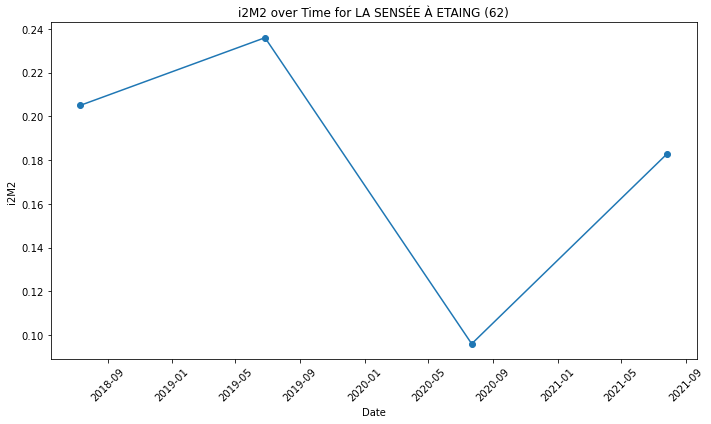

In [11]:
# Group by 'LbStationMesureEauxSurface' and aggregate the lists
grouped_df = Bio_df.groupby('LbStationMesureEauxSurface').apply(
    lambda x: pd.Series({
        'i2M2': list(x.sort_values(by='Date')['i2M2']),
        'Date': list(x.sort_values(by='Date')['Date'])
    })
)

# Example of accessing the data for a specific station label
station_label = 'LA SENSÉE À ETAING (62)'  # Replace with an actual station label
if station_label in grouped_df.index:
    # Extracting the data for the specific station
    data_for_station = grouped_df.loc[station_label]
    dates = data_for_station['Date']
    res_indices = data_for_station['i2M2']

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dates, res_indices, marker='o')  # 'o' for circle markers
    plt.title(f"i2M2 over Time for {station_label}")
    plt.xlabel('Date')
    plt.ylabel('i2M2')
    plt.xticks(rotation=45)  # Rotates the date labels for better readability
    plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
    plt.show()
else:
    print(f"No data found for station label {station_label}")



#### Identifier les stations pour lesquels on a pas d'i2M2

In [12]:
Stations_df = pd.read_csv('data/naiades_export/France_entiere/Stations/StationMesureEauxSurface.csv', sep=',', header=0)

Stations_mauvaise_proj = Stations_df[Stations_df['ProjStationMesureEauxSurface'] != 26]
Stations_mauvaise_proj = Stations_mauvaise_proj[['LbStationMesureEauxSurface']]
Stations_mauvaise_proj = Stations_mauvaise_proj.drop_duplicates()

Stations_df = Stations_df[~Stations_df['LbStationMesureEauxSurface'].isin(Stations_mauvaise_proj['LbStationMesureEauxSurface'])]

Stations_df = Stations_df[['LbStationMesureEauxSurface', 'CoordXStationMesureEauxSurface', 'CoordYStationMesureEauxSurface']]

# Convert DataFrame to GeoDataFrame
# Assuming 'CoordXStationMesureEauxSurface' is longitude and 'CoordYStationMesureEauxSurface' is latitude
gdf_stations = gpd.GeoDataFrame(
    Stations_df,
    geometry=gpd.points_from_xy(Stations_df.CoordXStationMesureEauxSurface, Stations_df.CoordYStationMesureEauxSurface)
)

# Set the coordinate reference system (CRS) for the GeoDataFrame
# Lamber-93 EPSG is 2154
gdf_stations.set_crs(epsg=2154, inplace=True)

# ### Loading the shapefile
# 
# Load the shapefile
gdf_regions = gpd.read_file("/home/orfeu/Documents/cours/3A/Cours_d_eau/Projet-cours-d-eau/Projet-cours-d-eau/data/naiades_export/HER//Hydroecoregion1.shp")

# Reproject to Lambert-93
gdf_regions = gdf_regions.to_crs(epsg=2154)

# ### Utiliser la map shapefile pour ajouter les HER au dataframe Station
# Perform a spatial join
joined = gpd.sjoin(gdf_stations, gdf_regions, how="inner", op='within')

# ### Exploration du dataframe avec les Stations et leur HER 
joined_cleaned = joined[['NomHER1', 'LbStationMesureEauxSurface']]
joined_cleaned = joined_cleaned.drop_duplicates(subset='LbStationMesureEauxSurface')


stations_not_in_grouped = joined_cleaned[~joined_cleaned['LbStationMesureEauxSurface'].isin(grouped_df.index)]
station_list = stations_not_in_grouped['LbStationMesureEauxSurface'].tolist()


/tmp/ipykernel_2182758/1069486897.py:1: DtypeWarning: Columns (0,15) have mixed types. Specify dtype option on import or set low_memory=False.
  Stations_df = pd.read_csv('data/naiades_export/France_entiere/Stations/StationMesureEauxSurface.csv', sep=',', header=0)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
print(len(joined_cleaned))
print(len(grouped_df.index))
print(len(station_list))


32385
8803
23637


#### Identifier l'HER pour lequel on a le plus d'i2M2

In [23]:
# test if all stations in grouped_df are in joined_cleaned

list_bool = []
list_false = []

# Iterate over each station label in grouped_df
for station_label in grouped_df.index:
    # Check if the station label is in the LbStationMesureEauxSurface column of joined_cleaned
    if station_label in joined_cleaned['LbStationMesureEauxSurface'].values:
        list_bool.append(True)
    else:
        list_bool.append(False)
        list_false.append(station_label)

print(all(list_bool))
print(list_false)

print(len(list_bool))
print(len(list_false))

False
['AGNY A NIVOLAS-VERMELLE ', 'AITELENE A AITON ', 'ANZON À GOURNAY', 'ARVE A VEYRIER', "BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE ", 'BOURBRE A CHAVANOZ ', 'BUGEON A LA-CHAMBRE ', 'CAIROS A SAORGE', 'CHAMBURAZ A CHENS-SUR-LEMAN ', 'COPPY A MAXILLY-SUR-LEMAN 1', 'GRAVONE A AJACCIO 1', 'HERMANCE A CHENS-SUR-LEMAN ', "L'HOGNEAU À GUSSIGNIES (59)", "L'Uhartea à Urrugne (Aval pont RN 10, amont de la confluenc", "L'Untxin à Urrugne (Pont du cc Château d'Urtubieà Urrugne", "L'YSER À BAMBECQUE (59)", 'LA LAUTER À LAUTERBOURG (B)', 'LA MARCHE À SAPOGNE-SUR-MARCHE', "LE COURS D'EAU NUMÉRO 01 DE LA COMMUNE DE GENAINVILLE A HOD", "LE COURS D'EAU NUMÉRO 01 DE LA COMMUNE DE VAUCLAIX A MHERE ", "LE COURS D'EAU NUMÉRO 01 DU MARAIS MAUDIT A MISSY-SUR-AISNE", 'LE FOSSÉ NUMÉRO 01 DE LA COMMUNE DE GEVROLLES A GEVROLLES ', 'LE LERTZBACH À HEGENHEIM', "LE RUISSEAU DE L'ÉTANG DE PARFOND RUPT À VIGNEULLES-LES-HA", 'LE RUISSEAU DE LA CRESSONNIÈRE A SAINT-MARTIN-DE-BIENFAITE-', 'LONGET A VALLEIRY 3', 'La Bi

In [17]:
nom_her_list = joined_cleaned['NomHER1'].tolist()

# Create an empty dictionary
her_dict = {}


for nom_her_list in nom_her_list:
    her_dict[nom_her_list] = 0
    
    for station_label_i2M2, data_for_station in grouped_df.iterrows():

        nom_her_station = joined_cleaned[joined_cleaned['LbStationMesureEauxSurface'] == station_label_i2M2]['NomHER1'].values[0]
        if nom_her_station == nom_her_list:
            her_dict[nom_her_list] += 1
    

# Print the dictionary
print(her_dict)


IndexError: index 0 is out of bounds for axis 0 with size 0